In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv1D, \
                         Flatten, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
data.shape

(8732, 8)

In [4]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

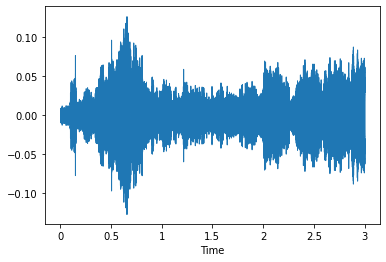

In [5]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', mono=True ,duration=3)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax)

In [6]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [30]:
#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset

    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/audio/' + row.path, duration=3)  #2.97 = 3*1000 - 3*1000/128  ###############################
        D.append( (y, row.classID) )
    np.save('raw_train_data.npy', D) ###############################
    return D
D = creates_train_data()

KeyboardInterrupt: 

Each time if you want to create a new '.npy' file 
MAKE SURE you delete the previous(old) one in the directory!!!! 

In [ ]:
print("Number of samples: ", len(D))

In [10]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [7]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('raw_train_data.npy')
a = np.load('train_data.npy')
b = np.load('train_data_augmented_speed_81.npy')
c = np.load('train_data_augmented_speed_107.npy')
d = np.load('train_data_augmented_ps1_2.npy')
e = np.load('train_data_augmented_ps2_m25.npy')
#np.savez('train.npz',a,b,c,d,e) ############################################################################
#r = np.load('train.npz') ############################################################################
#locals().update(r) ############################################################################
tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
# np.load.__defaults__=(None, True, True, 'ASCII')
# a = np.load('raw_train_data.npy')
dataset = tuplearr
random.shuffle(dataset)
len(dataset)

37303

In [8]:
len(a[746][0])

128

In [9]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

In [18]:
count = 0

for train_set, test_set in kf.split(dataset):
     print( train_set, test_set)
     print("-----------breaking line--------------")
     #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]
 
     print('----------------------------')
     count += 1
     print(count)
     print('----------------------------')
 
     X_train, y_train = zip(*dataset[train_set])
     X_test, y_test = zip(*dataset[test_set])
 
     # Reshape for CNN input
     X_train = np.array([x.reshape( (16384, 1) ) for x in X_train])
     X_test = np.array([x.reshape( (16384, 1) ) for x in X_test])
 
     # One-Hot encoding for classes
     y_train = np.array(keras.utils.to_categorical(y_train, 10))
     y_test = np.array(keras.utils.to_categorical(y_test, 10))
 
     NAME = "graphic-{}-".format(int(time.time()))
     tensorboard = TensorBoard(log_dir='G{}'.format(NAME +  str(count)))
 
 
     model = Sequential()

     model.add(
        Conv1D(24, kernel_size=(80), input_shape=(16384, 1))
        )

     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
 
     model.add(Conv1D(48, kernel_size=(3), padding="valid"))
     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
 
     model.add(Conv1D(48, kernel_size=(3), padding="valid"))
     model.add(Activation('relu'))
 
     model.add(Flatten())
     model.add(Dropout(rate=0.5))
 
     model.add(Dense(64))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.5))
 
     model.add(Dense(10))
     model.add(Activation('softmax'))
 
     #convnet = tflearn.DNN(model, tensorboard_dir='log')
 
     model.compile(
 	    optimizer="Adam",
 	    loss="categorical_crossentropy",
 	    metrics=['accuracy']
        )
 
     model.fit(
 	    x=X_train, 
 	    y=y_train,
        epochs=12,
        batch_size=128,
        validation_data= (X_test, y_test),
 	    callbacks=[tensorboard]
 	    )
 
     score = model.evaluate(
 	    x=X_test,
 	    y=y_test
        )
 
     print('Test loss:', score[0])
     print('Test accuracy:', score[1])

    

    


[ 3731  3732  3733 ... 37300 37301 37302] [   0    1    2 ... 3728 3729 3730]
-----------breaking line--------------
----------------------------
1
----------------------------
Epoch 1/12
  1/263 [..............................] - ETA: 0s - loss: 6.7486 - accuracy: 0.0625WARNING:tensorflow:From C:\Users\Guest1\anaconda3\envs\backup_20220216_20220322\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
263/263 [==============================] - 91s 346ms/step - loss: 1.6981 - accuracy: 0.4279 - val_loss: 0.9290 - val_accuracy: 0.7100
Epoch 2/12
263/263 [==============================] - 89s 337ms/step - loss: 1.1739 - accuracy: 0.5985 - val_loss: 0.6754 - val_accuracy: 0.7858
Epoch 3/12
263/263 [==============================] - 88s 333ms/step - loss: 0.9805 - accuracy: 0.6706 - val_loss: 0.5093 - val_accuracy

In [ ]:
#model.save('SoundClassificationTEST.model')

In [22]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [80]:
filename = ""

#Audio-Convertor
def audioCon(filename):
   from os import path
   from pydub import AudioSegment
   
   # files                                                                         
   src = "Test/{filename}.mp3"
   dst = "Test/{filename}.wav"
   
   # convert wav to mp3                                                            
   sound = AudioSegment.from_mp3(src)
   sound.export(dst, format="wav")

In [ ]:
audioCon()

In [81]:
def prepare(filepath):
    y, sr = librosa.load(filepath, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps.shape
    return ps.reshape(-1, 128, 128, 1)

In [3]:
model = tf.keras.models.load_model("SoundClassification.model")

In [4]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 62, 24)        0         
_________________________________________________________________
activation_65 (Activation)   (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 29, 48)         0         
_________________________________________________________________
activation_66 (Activation)   (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 2, 25, 48)       

In [83]:
prediction = model.predict([prepare('Test/airc.wav')])
max = np.amax(prediction)
print(max)
print(prediction)

0.90739536
[[9.0739536e-01 1.0987020e-05 7.2039278e-05 7.7610814e-05 1.3195210e-02
  9.4531840e-03 1.2650190e-07 6.9615506e-02 4.5010489e-05 1.3501685e-04]]
